In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub

In [9]:
df = pd.read_csv(r'nlp-getting-started/train.csv')

In [10]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
#nnlm-en-dim50 - embedding

In [12]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = df['text']
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [13]:
!ls

Data Cleaning.ipynb
NG_Test_Notebook.ipynb
NLP_EDA_CLEANING_ ROUND_1.ipynb
NLP_EDA_CLEANING_ ROUND_2.ipynb
NLP_EDA_CLEANING_ ROUND_3.ipynb
NLP_EDA_CLEANING_ ROUND_4.ipynb
NLP_EDA_CLEANING_ ROUND_5.ipynb
NLP_MAIN_CLEANING.ipynb
README.md
TF_GPU Notebook.ipynb
final_clean_text.csv
nlp-getting-started
preprocessed_clean_text.csv


In [14]:
cleaned = pd.read_csv('final_clean_text.csv')

In [15]:
data = cleaned[['text','target']]

In [16]:
data

,text,target
0,reason,1
1,forest fire near la canada,1
2,resident ask shelter place officer evacuation ...,1
3,people evacuation order california,1
4,get send photo smoke school,1
...,...,...
7608,giant crane hold bridge collapse nearby home,1
7609,control wild fire california northern state,1
7610,m utc km s volcano hawaii,1
7611,police investigate e bike collide car little e...,1


In [17]:
data.dropna(subset='text',inplace=True)

C:\Users\Nel-Jiren\AppData\Local\Temp\ipykernel_17356\1237765203.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset='text',inplace=True)


In [18]:
data

,text,target
0,reason,1
1,forest fire near la canada,1
2,resident ask shelter place officer evacuation ...,1
3,people evacuation order california,1
4,get send photo smoke school,1
...,...,...
7608,giant crane hold bridge collapse nearby home,1
7609,control wild fire california northern state,1
7610,m utc km s volcano hawaii,1
7611,police investigate e bike collide car little e...,1


In [36]:
clean = pd.read_csv('preprocessed_clean_text.csv')

In [37]:
data = clean[['text','target']]

In [38]:
data

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [39]:
train,val,test = np.split(data.sample(frac=1),[int(0.8*len(data)),int(0.9*len(data))])

In [40]:
train['target'] = train['target'].astype(np.float32)
val['target'] = val['target'].astype(np.float32)
test['target'] = test['target'].astype(np.float32)

In [41]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)


In [42]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [43]:
#Embedding
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding,dtype=tf.string,trainable=True)

In [44]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 0.18718316, -0.16279756,  0.01846922, ...,  0.02656788,
         0.13446012,  0.03619238],
       [ 0.88413715, -0.27356896,  0.11776199, ...,  0.33018842,
        -0.13634177,  0.2885421 ],
       [ 0.27252588, -0.18681182, -0.03018343, ..., -0.06688429,
         0.01787868,  0.10180864],
       ...,
       [ 0.2948702 ,  0.08937348, -0.13565744, ..., -0.20212705,
         0.0261076 ,  0.17015174],
       [ 0.3792855 , -0.01791629, -0.04128888, ...,  0.02639803,
         0.18510103,  0.10991494],
       [ 0.35880083,  0.33051023,  0.11658876, ...,  0.07809851,
        -0.11142856,  0.00438952]], dtype=float32)>

In [45]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [47]:
history = model.fit(train_data,epochs=10,validation_data = val_data)

Epoch 1/10
191/191 [==============================] - 5s 23ms/step - loss: 0.5625 - accuracy: 0.7279 - val_loss: 0.4716 - val_accuracy: 0.7819
Epoch 2/10
191/191 [==============================] - 4s 23ms/step - loss: 0.3494 - accuracy: 0.8535 - val_loss: 0.4771 - val_accuracy: 0.7792
Epoch 3/10
191/191 [==============================] - 4s 23ms/step - loss: 0.1907 - accuracy: 0.9279 - val_loss: 0.5821 - val_accuracy: 0.7727
Epoch 4/10
191/191 [==============================] - 4s 23ms/step - loss: 0.0958 - accuracy: 0.9672 - val_loss: 0.7509 - val_accuracy: 0.7608
Epoch 5/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0545 - accuracy: 0.9823 - val_loss: 0.8246 - val_accuracy: 0.7582
Epoch 6/10
191/191 [==============================] - 5s 24ms/step - loss: 0.0382 - accuracy: 0.9851 - val_loss: 0.9330 - val_accuracy: 0.7530
Epoch 7/10
191/191 [==============================] - 5s 24ms/step - loss: 0.0290 - accuracy: 0.9908 - val_loss: 0.9744 - val_accuracy: 0.7648

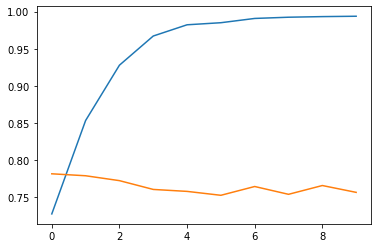

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


In [49]:
#LSTM

In [50]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [51]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for',
       'on', 'you', 'my', 'with', 'it', 'that', 'by', 'at', 'this'],
      dtype='<U17')

In [68]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
    input_dim = len(encoder.get_vocabulary()),
    output_dim=32,
    mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [69]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [70]:
history2 = model2.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/10
191/191 [==============================] - 7s 19ms/step - loss: 0.5637 - accuracy: 0.7046 - val_loss: 0.4524 - val_accuracy: 0.7898
Epoch 2/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3929 - accuracy: 0.8335 - val_loss: 0.4632 - val_accuracy: 0.7924
Epoch 3/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3464 - accuracy: 0.8614 - val_loss: 0.4942 - val_accuracy: 0.7819
Epoch 4/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3131 - accuracy: 0.8750 - val_loss: 0.4973 - val_accuracy: 0.7779
Epoch 5/10
191/191 [==============================] - 3s 15ms/step - loss: 0.2872 - accuracy: 0.8877 - val_loss: 0.5548 - val_accuracy: 0.7635
Epoch 6/10
191/191 [==============================] - 3s 14ms/step - loss: 0.2506 - accuracy: 0.9036 - val_loss: 0.6432 - val_accuracy: 0.7595
Epoch 7/10
191/191 [==============================] - 3s 13ms/step - loss: 0.2187 - accuracy: 0.9179 - val_loss: 0.6764 - val_accuracy: 0.7556

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.show()

ImportError: DLL load failed while importing _openmp_helpers: Not enough memory resources are available to process this command.